## Define the Convolutional Neural Network

After you've looked at the data your working with and, in this case, know the shape of the images, and the faces and keypoints in each image, you are ready to define a convolutional neural network that can learn from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers that will evolve during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

In [2]:
## TODO: Define the Net in models.py

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (maxPool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (linear1): Linear(in_features=20000, out_features=5000, bias=True)
  (linear2): Linear(in_features=5000, out_features=2500, bias=True)
  (linear3): Linear(in_features=2500, out_features=500, bias=True)
  (output_layer): Linear(in_features=500, out_features=136, bias=True)
  (drop1): Dropout2d(p=0.3)
  (drop2): Dropout2d(p=0.15)
  (drop3): Dropout2d(p=0.1)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.


In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor


# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())


Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

In [4]:
# load training data in batches
batch_size = 20

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [5]:
# load in the test data, using the dataset class

data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [6]:
# load test data in batches
batch_size = 20

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and groud truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [7]:
# test the model on a batch of test images

def net_sample_output():
    
    # Iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data
        images = sample['image']
        key_pts = sample['keypoints']
        
        # wrap image in Variable and convert to FloatTensor type
        images = Variable(images)
        images = images.type(torch.FloatTensor)
        
        # forward pass to get net output
        print(images.size())
        output_pts = net(images)
        print(output_pts.size())
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [8]:
# call the above function
test_images, test_outputs, gt_pts = net_sample_output()
print("start")
print(test_images.data.size())
print("mid")
print(test_outputs.data.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 136])
start
torch.Size([20, 1, 224, 224])
mid
torch.Size([20, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

In [9]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')


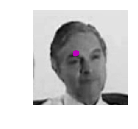

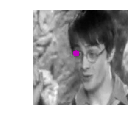

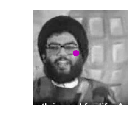

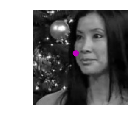

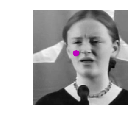

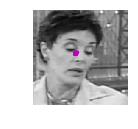

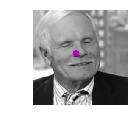

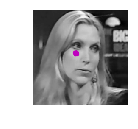

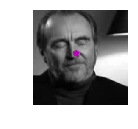

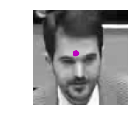

In [10]:
# visualize the output
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the key_pts data
        key_pts = test_outputs[i].data
        key_pts = key_pts.numpy()
        # undo normalization of keypoints  
        key_pts = key_pts*50.0+100
        
        show_keypoints(np.squeeze(image), key_pts)

        # plot ground truth points for comparison
        if gt_pts is not None:  
            gt_pts_new = gt_pts.data
            plt.scatter(gt_pts_new[:, 0], gt_pts_new[:, 1], s=15, marker='.', c='g')
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [11]:
## TODO: Define the loss and optimization
import torch.optim as optim

# SmoothL1Loss less senstive to outliers than MSE
criterion = nn.modules.loss.SmoothL1Loss()

# note: since Net object inherits from the nn.Module base class. All objects inheriting from this class have a method
# parameters() that returns an iterable of the model's parameters that can be used to tell the optimizer what to optimize
# on
params = net.parameters()
optimizer = optim.RMSprop(params, lr=0.0003)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start of with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [12]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # wrap them in a torch Variable
            images, key_pts = Variable(images), Variable(key_pts)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            net.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.data[0]
            if batch_i % batch_size == batch_size - 1:    # print every 10 mini-batches
                #loss_over_time.append(running_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [13]:
# train your network
n_epochs = 5 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)
# NOTE: I know my network doesn't seem to train. the loss doesn't budge and then the example output it just seems
# to output on one dot. I can't seem to figure out why it only outputs a dot / doesn't train at all as I tried to replicate
# the architecture of this same project I did but in Keras.

Epoch: 1, Batch: 20, Avg. Loss: 0.011378136076033116
Epoch: 1, Batch: 40, Avg. Loss: 0.002232771348208189
Epoch: 1, Batch: 60, Avg. Loss: 0.0019477682858705522
Epoch: 1, Batch: 80, Avg. Loss: 0.0019419600665569305
Epoch: 1, Batch: 100, Avg. Loss: 0.00192035623639822
Epoch: 1, Batch: 120, Avg. Loss: 0.002002910003066063
Epoch: 1, Batch: 140, Avg. Loss: 0.0020893770083785057
Epoch: 1, Batch: 160, Avg. Loss: 0.0020654424764215947
Epoch: 2, Batch: 20, Avg. Loss: 0.0019511013925075532
Epoch: 2, Batch: 40, Avg. Loss: 0.0018158493563532828
Epoch: 2, Batch: 60, Avg. Loss: 0.0017935102805495262
Epoch: 2, Batch: 80, Avg. Loss: 0.0019138893149793148
Epoch: 2, Batch: 100, Avg. Loss: 0.0017140032947063446
Epoch: 2, Batch: 120, Avg. Loss: 0.0016217537000775338
Epoch: 2, Batch: 140, Avg. Loss: 0.001650652877986431
Epoch: 2, Batch: 160, Avg. Loss: 0.0015930912680923938
Epoch: 3, Batch: 20, Avg. Loss: 0.0016850274316966534
Epoch: 3, Batch: 40, Avg. Loss: 0.0018268614560365676
Epoch: 3, Batch: 60, Avg. 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [14]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 136])
torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])


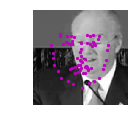

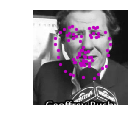

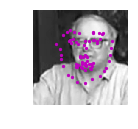

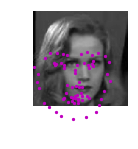

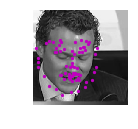

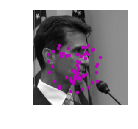

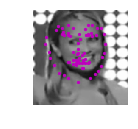

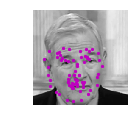

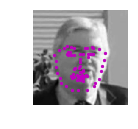

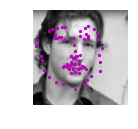

In [15]:
visualize_output(test_images, test_outputs)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [16]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'HarrisonWorkingModelOne.pt'

# after training, save your model in the dir 'models'
torch.save(net, model_dir+model_name)


After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: Chose the smooth L1 loss function as after reading from the linked documentation it looked like it was what I wanted for a regression problem but I liked the fact it was less sensitive to outliers than the MSE so I chose it. The optimization Adam was chosen this time as it worked well on the previous project so I just stuck with that and I know it's a pretty common one to use. Need to go back and test with other optimizers though.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started by trying to replicate my network architecture found in the Keras computer vision capstone vision that got good results after just 10 epochs. I have a dropout layer to help with overfitting. Need to tweak and test more but training takes awhile on computer and currently don't have time in this go around

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: Kept them the same as the previous project. 20 seemed like a good amount of images to train on but also not too large and slowly down the training process considerably. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

[[ 0.00067124  0.02462746 -0.19088507  0.13531621]
 [ 0.10846561  0.23232152 -0.09077176 -0.08691528]
 [-0.12437689 -0.20719036 -0.09899008  0.22266079]
 [-0.10013379  0.24498442 -0.17635871  0.09590993]]
(4, 4)
(4, 4)
<class 'numpy.ndarray'>


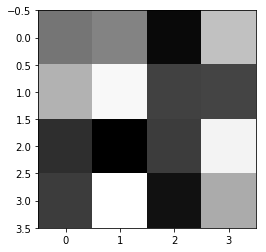

In [17]:
# Get the weights in the first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
print(w[filter_index][0].shape)
print(type(w[filter_index][0]))
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is comprosed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detect the corners of eyes. You can see what kind of features each of these ernesl detects by applying them to an image.

Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

<class 'numpy.ndarray'>
(1, 224, 224)


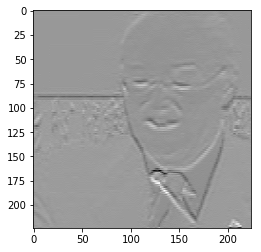

In [18]:
##TODO: load in and display any image from the test dataset
# picking just the first image for the test_images list
test_image = test_images[0]
# see: https://stackoverflow.com/questions/44340848/how-to-convert-pytorch-autograd-variable-to-numpy
# basically, a quick way to convert torch Variable to its numpy nd array equivalent
test_image = test_image.data.numpy()
## TODO: use cv's filter2D function 
# apply a specific set of filter weights (like the one displayed above) to the test image
# taking the kernel that we plot above to use 
kernel = w[filter_index][0]
import cv2
print(type(test_image))
# using filter2D method and applying the kernel to the test image
filtered_test_image = cv2.filter2D(test_image, -1, kernel)
print(filtered_test_image.shape)
# note: since the test_image is still 3D array but really the third dimension is just empty as it comes from a greater
# list of multiple images, we just take the 'first' one within this ndarray to get the actually 2D array that represents 
# our test image
filtered_test_image = filtered_test_image[0]
plt.imshow(filtered_test_image, cmap='gray')


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: It looks to blur out noise and focus on and detect areas with homogenous coloring (if I'm reading the plot correctly)

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!